In [25]:
from scipy import stats, sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [13]:
ROOT = Path('.').absolute().parent
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

In [14]:
[*RAW_DATA_DIR.rglob('*')]

[PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/.ipynb_checkpoints'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/egfr_erbB1.h5'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train/sparse_train_X.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train/sparse_train_y.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test/sparse_test_y.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test/sparse_test_X.npz')]

# Load raw data

In [89]:
train_X_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_X.npz')
train_y_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_y.npz')

**To numpy arrays**

In [97]:
train_X = train_X_csr.toarray()
train_y = train_y_csr.toarray().squeeze()

# Try different tree based algorithms

In [64]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [87]:
param_distributions = {
    'n_estimators': stats.randint(50, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': stats.randint(1, 15),
    'min_samples_leaf': stats.randint(5, 50),
    'max_features': ['sqrt', 'log2']
}

In [119]:
rndcv_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_distributions,
                              n_iter=50, scoring='recall', cv=5, random_state=123,
                             return_train_score=True, verbose=2, n_jobs=-1)

In [120]:
rndcv_rf.fit(train_X, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f818ce1b710>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f818ce15810>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f818ce1b690>},
                   random_state=123, return_train_score=True, scoring='recall',
                   verbose=2)

In [121]:
rndcv_rf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [122]:
rndcv_rf.cv_results_['mean_test_score']

array([0.92012674, 1.        , 1.        , 0.93419453, 0.99648135,
       1.        , 0.95002104, 0.92117689, 0.94475482, 0.95811839,
       0.92329266, 1.        , 0.99964789, 1.        , 1.        ,
       0.99964851, 1.        , 0.99824067, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.96164323, 0.92821666,
       0.92153333, 1.        , 0.92188297, 0.99577589, 1.        ,
       0.91836493, 1.        , 0.97219548, 0.99859279, 1.        ,
       0.99683346, 1.        , 0.95566289, 0.99331419, 1.        ,
       1.        , 1.        , 0.99824129, 0.99824067, 0.92926805,
       0.92646105, 0.93454603, 1.        , 1.        , 1.        ])

In [107]:
rndcv_rf.cv_results_['std_test_score']

array([0.00523189, 0.00041599, 0.00041599, 0.00677395, 0.00137573,
       0.00219774, 0.00777858, 0.00613339, 0.00494254, 0.00461301,
       0.00420046, 0.00041599, 0.00038502, 0.00041599, 0.00164587,
       0.0004822 , 0.00041599, 0.00152916, 0.00041599, 0.00041599])

In [115]:
best_results_mask = rndcv_rf.cv_results_['mean_test_score'] > 0.85

In [116]:
rndcv_rf.cv_results_['param_criterion'][best_results_mask]

masked_array(data=['gini', 'gini', 'entropy'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object)

In [117]:
rndcv_rf.cv_results_['param_max_depth'][best_results_mask]

masked_array(data=[14, 14, 13],
             mask=[False, False, False],
       fill_value='?',
            dtype=object)

**Parameter distributions**

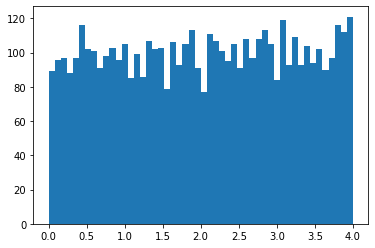

In [34]:
x = stats.uniform(loc=0, scale=4).rvs(5000)
plt.hist(x, bins=50);

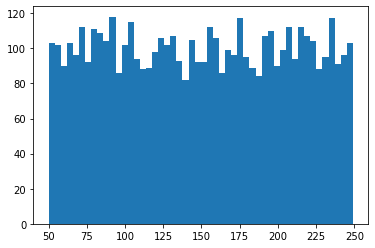

In [74]:
x = stats.randint(50, 250).rvs(5000)
plt.hist(x, bins=50);

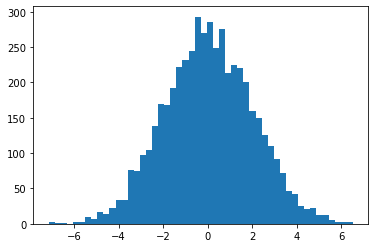

In [35]:
x = stats.norm(loc=0, scale=2).rvs(5000)
plt.hist(x, bins=50);

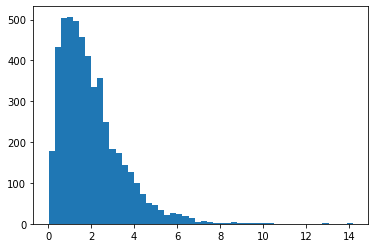

In [32]:
x = stats.gamma(1.99).rvs(5000)
plt.hist(x, bins=50);

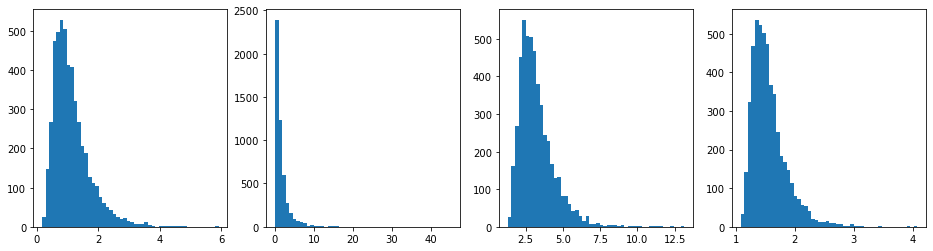

In [42]:
fig, axs = plt.subplots(figsize=(16,4), ncols=4)

x = stats.lognorm(s=.5).rvs(5000)
axs[0].hist(x, bins=50)

x = stats.lognorm(s=1.).rvs(5000)
axs[1].hist(x, bins=50)

x = stats.lognorm(s=.5, loc=1., scale=2).rvs(5000)
axs[2].hist(x, bins=50)

x = stats.lognorm(s=.5, loc=1., scale=.5).rvs(5000)
axs[3].hist(x, bins=50);

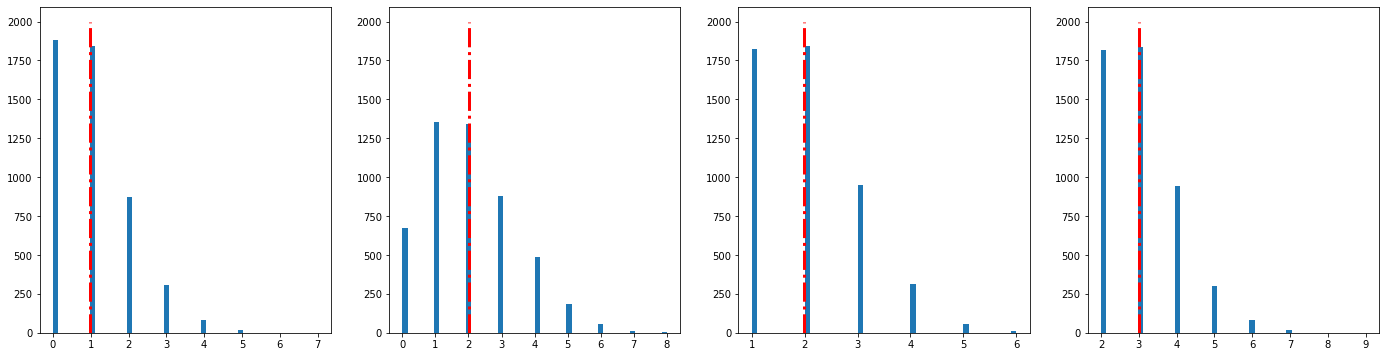

In [62]:
fig, axs = plt.subplots(figsize=(24,6), ncols=4)

x = stats.poisson(mu=1).rvs(5000)
axs[0].hist(x, bins=50)
axs[0].plot([x.mean()]*500, np.arange(0, 2000, 4), lw=3., color='red', linestyle='-.');

x = stats.poisson(mu=2).rvs(5000)
axs[1].hist(x, bins=50)
axs[1].plot([x.mean()]*500, np.arange(0, 2000, 4), lw=3., color='red', linestyle='-.');

x = stats.poisson(mu=1, loc=1.).rvs(5000)
axs[2].hist(x, bins=50)
axs[2].plot([x.mean()]*500, np.arange(0, 2000, 4), lw=3., color='red', linestyle='-.');

x = stats.poisson(mu=1, loc=2.).rvs(5000)
axs[3].hist(x, bins=50);
axs[3].plot([x.mean()]*500, np.arange(0, 2000, 4), lw=3., color='red', linestyle='-.');

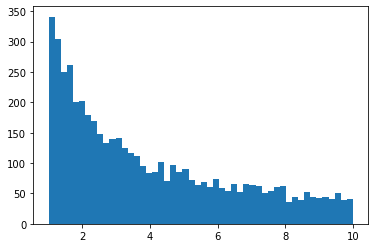

In [83]:
a, b = 1, 10
x = stats.loguniform(a, b).rvs(5000)
plt.hist(x, bins=50);